In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import sys
import gc
from time import time
from collections import Counter
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm
import wandb
import glob
import random
import seaborn as sns

wandb.login()

sys.path.insert(0,'../src/')

# -----
from datap_efficient import *
from model_train import *
from labeling_system import *
import cvt as cvt
import cvt_benchmark as cvtb

In [2]:
labels = np.load('../output/benchmark/labels_test_bench_final_final.npy', allow_pickle=True)
outputs = np.load('../output/benchmark/outputs_test_bench_final_final.npy', allow_pickle=True)
results = np.load('../output/benchmark/results_runs_bench_final_final.npy', allow_pickle=True)
results_class = np.load('../output/benchmark/results_runs_class_bench_final_final.npy', allow_pickle=True)

In [3]:
results[0][1][0]

[0.5475631356239319,
 0.5285357142857143,
 0.5350398083884388,
 0.5285357142857143,
 0.5164443783566649,
 0.9589952386182763,
 0.5914888243465084,
 0.6369219069977323,
 0.5914503167092859,
 0.5748227966553863]

In [18]:
result_1 = results[0][1]

In [19]:
train_loss = []
for i in result_1:
    train_loss.append(result_1[i][0])

print(len(train_loss), train_loss[:4])

40 [0.5475631356239319, 0.38434913434301105, 0.33206782669680457, 0.3058499150446483]


In [20]:
train_acc = []
for i in result_1:
    train_acc.append(result_1[i][1])

print(len(train_acc), train_acc[:4])

40 [0.5285357142857143, 0.6585357142857143, 0.7032857142857143, 0.7315714285714285]


In [21]:
train_prec = []
for i in result_1:
    train_prec.append(result_1[i][2])

print(len(train_prec), train_prec[:4])

40 [0.5350398083884388, 0.6635221706880521, 0.7082381770426462, 0.7368103905718382]


In [22]:
train_recall = []
for i in result_1:
    train_recall.append(result_1[i][3])

print(len(train_recall), train_recall[:4])

40 [0.5285357142857143, 0.6585357142857142, 0.7032857142857143, 0.7315714285714285]


In [23]:
train_F1 = []
for i in result_1:
    train_F1.append(result_1[i][4])

print(len(train_F1), train_F1[:4])

40 [0.5164443783566649, 0.6550185998915032, 0.7020354309660621, 0.7309179607507139]


In [24]:
valid_loss = []
for i in result_1:
    valid_loss.append(result_1[i][5])

print(len(valid_loss), valid_loss[:4])

40 [0.9589952386182763, 0.8037982896461467, 0.7094509752053536, 0.6810869558665289]


In [25]:
valid_acc = []
for i in result_1:
    valid_acc.append(result_1[i][6])

print(len(valid_acc), valid_acc[:4])

40 [0.5914888243465084, 0.6659931809571915, 0.7301426947846951, 0.7398661447152418]


In [26]:
valid_prec = []
for i in result_1:
    valid_prec.append(result_1[i][7])

print(len(valid_prec), valid_prec[:4])

40 [0.6369219069977323, 0.6922755854839798, 0.7533920767398936, 0.7476564862426566]


In [27]:
valid_recall = []
for i in result_1:
    valid_recall.append(result_1[i][8])

print(len(valid_recall), valid_recall[:4])

40 [0.5914503167092859, 0.6659566866236902, 0.7301185171574256, 0.7398489059365765]


In [28]:
valid_F1 = []
for i in result_1:
    valid_F1.append(result_1[i][9])

print(len(valid_F1), valid_F1[:4])

40 [0.5748227966553863, 0.6586435834446818, 0.7307098693935552, 0.7373821177205525]


In [29]:
import seaborn

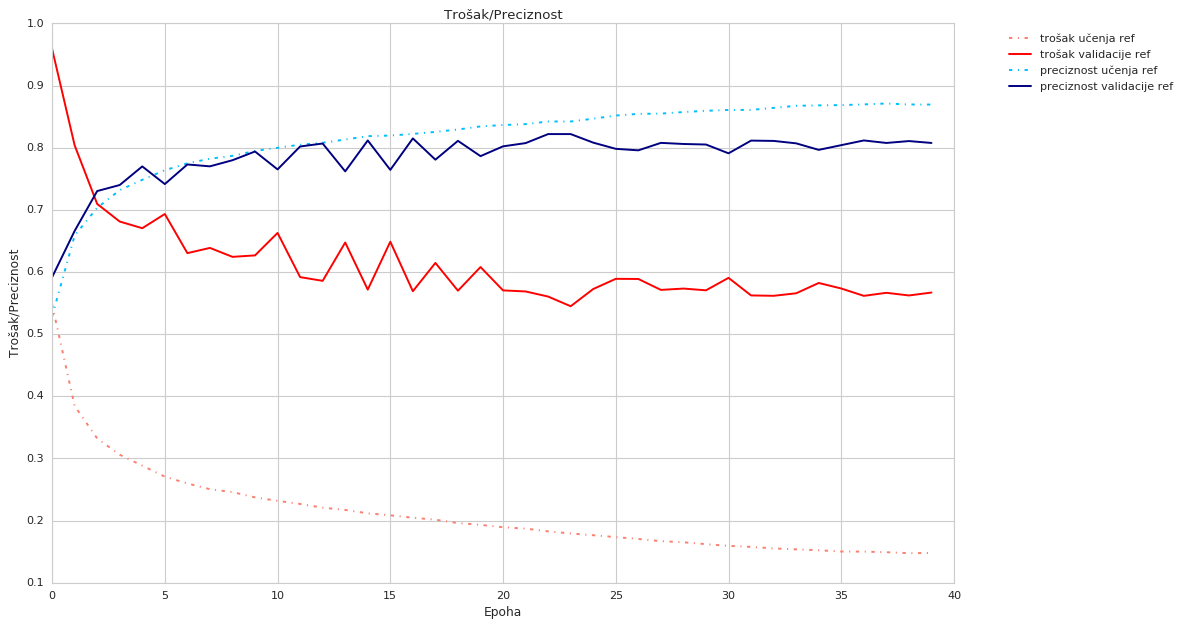

In [38]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15,8))

plt.plot(train_loss, color="salmon", linestyle="dashdot", label="trošak učenja ref")
plt.plot(valid_loss, color="red", label="trošak validacije ref")
plt.plot(train_acc, color="deepskyblue", linestyle="dashdot", label="preciznost učenja ref")
plt.plot(valid_acc, color="navy", label="preciznost validacije ref")
# oznaka x-osi
plt.xlabel("Epoha")
# oznaka y-osi
plt.ylabel("Trošak/Preciznost")
# naslov grafa
plt.title("Trošak/Preciznost")
# legenda
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

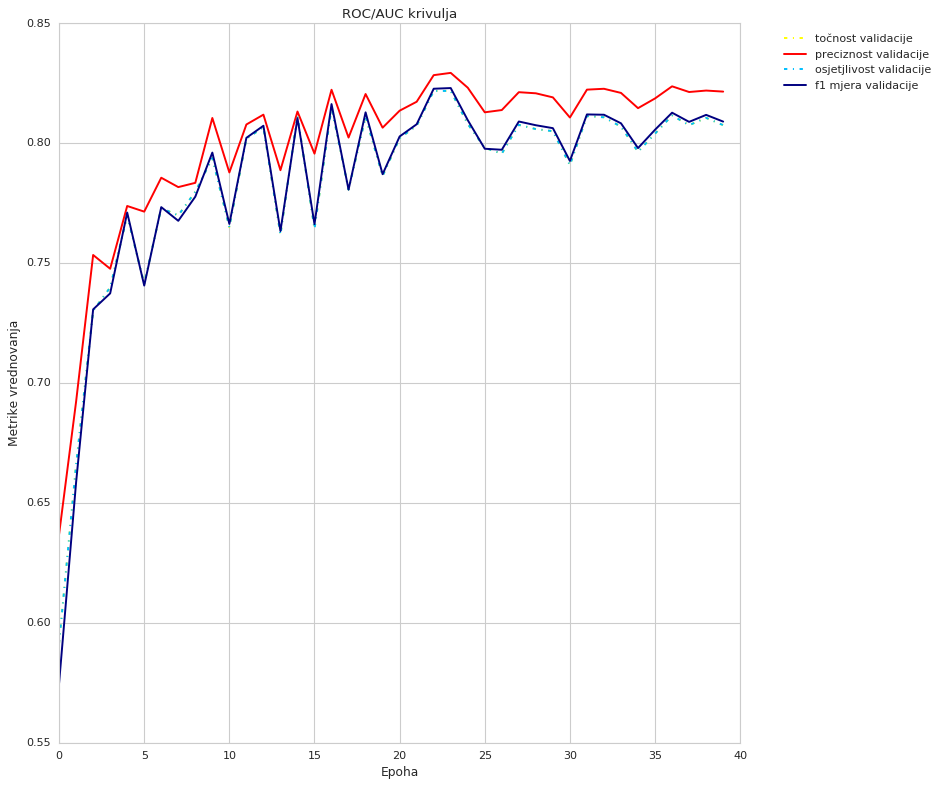

In [44]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12,10))

plt.plot(valid_acc, color="yellow", linestyle="dashdot", label="točnost validacije")
plt.plot(valid_prec, color="red", label="preciznost validacije")
plt.plot(valid_recall, color="deepskyblue", linestyle="dashdot", label="osjetjlivost validacije")
plt.plot(valid_F1, color="navy", label="f1 mjera validacije")
# oznaka x-osi
plt.xlabel("Epoha")
# oznaka y-osi
plt.ylabel("Metrike vrednovanja")
# naslov grafa
plt.title("ROC/AUC krivulja")
# legenda
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [45]:
labels

array([7., 1., 7., ..., 1., 7., 0.], dtype=float32)

In [46]:
outputs

array([7., 1., 7., ..., 1., 7., 0.], dtype=float32)

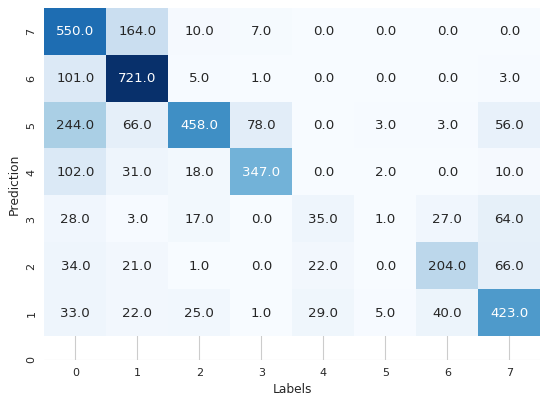

In [48]:
ct = pd.crosstab(outputs, labels, rownames=["Prediction"], colnames=["Labels"])
sns.heatmap(ct, cmap="Blues", annot=True, xticklabels="01234567", yticklabels="76543210", fmt=".1f", cbar=False)
plt.show()

In [6]:
main_runs = pd.read_csv('../input/main_runs.csv')

In [7]:
imgs_path = '../input/images_gz2/images/'

soft_label_dict_run1 = create_label_dict1(main_runs)
soft_label_dict_run2 = create_label_dict2(main_runs)

soft_run1_conf, soft_run1_spur = section_spurious(soft_label_dict_run1, num=3)
soft_run2_conf, soft_run2_spur = section_spurious(soft_label_dict_run2, num=7)

hard_run1_conf = create_hard_labels(soft_run1_conf)
hard_run2_conf = create_hard_labels(soft_run2_conf)

print(Counter(list(hard_run1_conf.values())))
print(Counter(list(hard_run2_conf.values())))

W, H, C = 224, 224, 4

conf_file_list = create_file_list(imgs_path, soft_run1_conf, soft_run2_conf)

Counter({0: 130557, 1: 56602, 2: 17603})
Counter({1: 69767, 0: 58485, 4: 51702, 5: 14903, 3: 13821, 2: 9566, 6: 6043})


In [10]:
conf_file_list[0]

('../input/images_gz2/images/100.jpg', 100)

In [11]:
int(os.path.splitext(os.path.basename(conf_file_list[0][0]))[0])

100

In [4]:
results1 = np.load('../extra/results_runs_final_final.npy', allow_pickle=True)
results_class1 = np.load('../extra/results_runs_class_final_final.npy', allow_pickle=True)

In [5]:
results1

array([['r1',
        {0: [0.5475631356239319, 0.5285357142857143, 0.5350398083884388, 0.5285357142857143, 0.5164443783566649, 0.9589952386182763, 0.5914888243465084, 0.6369219069977323, 0.5914503167092859, 0.5748227966553863], 1: [0.38434913434301105, 0.6585357142857143, 0.6635221706880521, 0.6585357142857142, 0.6550185998915032, 0.8037982896461467, 0.6659931809571915, 0.6922755854839798, 0.6659566866236902, 0.6586435834446818], 2: [0.33206782669680457, 0.7032857142857143, 0.7082381770426462, 0.7032857142857143, 0.7020354309660621, 0.7094509752053536, 0.7301426947846951, 0.7533920767398936, 0.7301185171574256, 0.7307098693935552], 3: [0.3058499150446483, 0.7315714285714285, 0.7368103905718382, 0.7315714285714285, 0.7309179607507139, 0.6810869558665289, 0.7398661447152418, 0.7476564862426566, 0.7398489059365765, 0.7373821177205525], 4: [0.2883335421085358, 0.74825, 0.752492370075948, 0.7482500000000001, 0.7481500640339579, 0.6703937355203601, 0.7697941659300417, 0.7738301036036083, 0.7

In [4]:
embed_size = 64

In [6]:
model_path = '../output/model_benchmark_final_final_epoch40.pth'
model = cvtb.CvT_bench(embed_size, 7)    
state_dict = torch.load(model_path)      
model.load_state_dict(state_dict)         
model.eval()            

CvT_bench(
  (stage1): VisionTransformer(
    (layers): Sequential(
      (0): Block(
        (mhsa): multi_head_attention(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Rearrange('b c h w -> b (h w) c')
          )
          (att_drop): Dropout(p=0.1, inplace=False)
        )
        (ff): MLP(
          (ff): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=256, out_features=64, bias=True)
            (4): Dropout(p=0.1, inplace=False)
          )
        )
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
 

In [8]:
main_runs = pd.read_csv('../input/main_runs.csv')
# ------

soft_label_dict_run1 = create_label_dict1(main_runs)
soft_label_dict_run2 = create_label_dict2(main_runs)

soft_run1_conf, soft_run1_spur = section_spurious(soft_label_dict_run1, num=3)
soft_run2_conf, soft_run2_spur = section_spurious(soft_label_dict_run2, num=7)

hard_run1_conf = create_hard_labels(soft_run1_conf)
hard_run2_conf = create_hard_labels(soft_run2_conf)

print(Counter(list(hard_run1_conf.values())))
print(Counter(list(hard_run2_conf.values())))

imgs_path = '../input/images_gz2/images/'
W, H, C = 224, 224, 4

conf_file_list = create_file_list(imgs_path, soft_run1_conf, soft_run2_conf)

n = 1000
bs = 128
images_orig, labels_orig = data_setup(conf_file_list, hard_run2_conf, n)
traino, valido, testo, y_traino, y_valido, y_testo = split_data(images_orig, labels_orig)

epochs = 1
lr = 1e-4
tmax = epochs
device= 'cuda' if torch.cuda.is_available() else 'cpu'
embed_size = 64

train_iter, valid_iter, test_iter = create_dali_iterators(traino, valido, testo, hard_run2_conf, bs)

KeyboardInterrupt: 